In [73]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import os
import re
from sklearn.model_selection import train_test_split

#!pip install vendi_score
from vendi_score import vendi

# Set seed for reproducibility!
np.random.seed(42) 

Create subsets for different source diversity levels using the dirichlet distribution's alpha parameter to control for concentration.

In [2]:
def vs_source(df):
    """
    Calculate Vendi Score for source dimension.
    Uses as similarity function the Euclidean Distance between reliability and bias
    """
    features= df[['reliability', 'bias']].to_numpy()
    distances= np.sqrt(np.sum((features[:, np.newaxis] - features[np.newaxis, :]) ** 2, axis=-1))
    similarity_matrix = 1 / (1 + distances)

    vs = vendi.score_K(similarity_matrix)
    return vs


def generate_random_distribution(dim, alpha, rep):
    """
    Generate Dirichlet-distributed samples
    - dim (int): Number of categories or dimensions for the Dirichlet distribution (unique sources)
    - alpha (float): Concentration parameter of the Dirichlet distribution.
    - rep (int): The number of random samples to generate

    Returns:
    - np.ndarray: A 2D array of shape (rep, dim), where each row is a Dirichlet-distributed 
      sample, with proportions summing up to 1.
    """
    return np.random.dirichlet([alpha] * dim, rep)


In [ ]:
def create_subsets(df, rep, subset_size):
    """
    Generate subsets of data using Dirichlet distributions for sampling proportions.

    Parameters:
    - df (pd.DataFrame): The input dataframe containing the data.
    - rep (int): The number of repetitions or samples to generate.
    - subset_size (int): The total number of samples to draw for each subset.

    Returns:
    - dict: A dictionary where keys are tuples of (alpha, index) and values are the 
      corresponding concatenated subsets of sampled data.
    """
    # Define parameters for Dirichlet sampling
    alpha_values = [0.001, 0.01 0.1, 0.5, 1, 1.5, 2, 5, 10, 100]
    ks = df["source"].unique()
    dim = len(ks)

    subsamples = {}

    for alpha in alpha_values:
        distributions = generate_random_distribution(dim, alpha, rep)

        # Collect samples 
        for idx, distribution in enumerate(distributions, start=1):
            remaining_samples = subset_size
            source_sample_sizes = {k: 0 for k in ks}
            max_sample_sizes = {k: len(df[df['source'] == k]) for k in ks}

            # First pass: Calculate sample size for each source based on Dirichlet distribution
            for k, sample_proportion in zip(ks, distribution):
                sample_size = int(subset_size * sample_proportion)
                source_sample_sizes[k] = min(sample_size, max_sample_sizes[k])  # Ensure we do not exceed available samples
                remaining_samples -= source_sample_sizes[k]

            available_sources = [k for k in ks if source_sample_sizes[k] + remaining_samples < max_sample_sizes[k]]
            if remaining_samples > 0 and available_sources:
                k = np.random.choice(available_sources)
                #available_space = max_sample_sizes[k] - source_sample_sizes[k]
                #additional_samples = min(remaining_samples, available_space)

                # Update sample sizes and remaining samples
                source_sample_sizes[k] += remaining_samples
                #remaining_samples -= additional_samples

                # Recompute available sources after allocation
                available_sources = [k for k in ks if source_sample_sizes[k] < max_sample_sizes[k]]

                sampled_data = []
                for k, sample_size in source_sample_sizes.items():
                    if sample_size > 0:
                        bin_data = df[df['source'] == k]
                        sampled_data.append(bin_data.sample(n=sample_size, replace=False))
                

                if sampled_data:
                    subset_df = pd.concat(sampled_data)
                    vendi_score = vs_source(subset_df) 
                    alpha_name = str(alpha).replace('.', '_')
                    subsamples[f"alpha_{alpha_name}_idx_{idx}"] = {
                        "data": subset_df,
                        "vs": vendi_score
                    }
                    
    # Generate perfectly uniform subsamples (equal proportions)
    inf_alpha = np.ones(dim) / dim  # Equal proportions for each score

    for idx in range(rep):
        remaining_samples = subset_size
        source_sample_sizes = {k: int(subset_size * inf_alpha[i]) for i, k in enumerate(ks)}
        max_sample_sizes = {k: len(df[df['source'] == k]) for k in ks}

        for k in ks:
            if source_sample_sizes[k] > max_sample_sizes[k]:
                remaining_samples =- ( max_sample_sizes[k] - source_sample_sizes[k])
                source_sample_sizes[k] = max_sample_sizes[k]  # Set to max available samples

                # Now, distribute remaining samples to available sources
                while remaining_samples > 0:
                    available_sources = [k for k in ks if source_sample_sizes[k] < max_sample_sizes[k]]

                    # Distribute one sample to each available source, checking that it doesn't exceed max sample size
                    for k in available_sources:
                        if remaining_samples > 0 and source_sample_sizes[k] < max_sample_sizes[k]:
                            source_sample_sizes[k] += 1
                            remaining_samples -= 1

        # Ensure that the total samples per source are within the available limits
        sampled_data = []
        for k, sample_size in source_sample_sizes.items():
            if sample_size > 0:
                bin_data = df[df['source'] == k]
                sampled_data.append(bin_data.sample(n=sample_size, replace=False))

        if sampled_data:
            subset_df = pd.concat(sampled_data)
            vendi_score = vs_source(subset_df)
            alpha_name = str(alpha).replace('.', '_')
            subsamples[f"alpha_inf_idx_{idx+1}"] = {
                "data": subset_df,
                "vs": round(vendi_score, 3)
            }


    return subsamples

In [103]:
def process_vendi_scores(subsamples):
    """
    Normalize Vendi scores by the maximum possible value and categorize them into quintiles.

    Parameters:
    - subsamples (dict): Dictionary of subsets with their data and VS

    Returns:
    - pd.DataFrame: A DataFrame containing subset keys, normalized Vendi scores, 
      and quintile categories.
    """
    # Extract subset keys and Vendi scores
    subset_keys = []
    vendi_scores = []

    for key, value in subsamples.items():
        subset_keys.append(key)
        vendi_scores.append(value['vs'])

    # Normalize the Vendi scores by the maximum value
    max_vendi = max(vendi_scores)
    normalized_scores = [round(score / max_vendi,3) for score in vendi_scores]

    # Categorize scores into quintiles
    quintiles = pd.qcut(normalized_scores, q=5, labels=[1, 2, 3, 4, 5])
    bin_edges = [i / 10 for i in range(11)]
    deciles = pd.cut(normalized_scores, bins=bin_edges, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

    for i, key in enumerate(subset_keys):
        subsamples[key]['normalized_vs'] = normalized_scores[i]
        subsamples[key]['quintile'] = int(quintiles[i])
        subsamples[key]['decile'] = int(deciles[i])

    alpha_pattern = r'_(\d+(?:_\d+)?|inf)_'
    alphas = [
        re.search(alpha_pattern, key).group(1).replace("_", ".") if re.search(alpha_pattern, key) else None
        for key in subset_keys
    ]

    for i, alpha in enumerate(alphas):
        if alpha is not None:
            if alpha == "inf":
                alphas[i] = float('inf')  # Convert 'inf' to Python's float('inf')
            else:
                alphas[i] = float(alpha)


    # Create a DataFrame for results
    result_df = pd.DataFrame({
        "subsample": subset_keys,
        "alpha": alphas,
        "vs": vendi_scores,
        "normalized_vs": normalized_scores,
        "quintile": [int(q) for q in quintiles],  
        "decile": [int(d) for d in deciles]
    })

    
    return result_df
 
def save_subsamples(subsamples, dataset):
    path = f"../data/subsamples/source/{dataset}/"
    if not os.path.exists(path):
        os.makedirs(path)

    for alpha_key, value in subsamples.items():
        sampled_df = value['data']

        filename = f"{alpha_key}.csv"
        full_path = os.path.join(path, filename)
        
        # Save the dataframe as a CSV
        sampled_df.to_csv(full_path, index=False)


We have to generate train, test split for each dataset, so that each subset is tested against the same unseen data. 
* Should we test everything in an OOD dataset?
* If we are going to use the same subset sample for datasets, then use same test sample for all as well.

In [104]:
# BASIL:  "For the sentence-level classifiers, both our informational and lexical models use 6,819 sentences for training, 758 for validation, and 400 for testing"
basil = pd.read_csv("../data/processed/basil.csv")

basil_train, basil_test = train_test_split(basil, test_size=600)
basil_train.to_csv("../data/processed/basil_train.csv")
basil_test.to_csv("../data/processed/basil_test.csv")

# ANNOMATIC: Use the BABE dataset as val/test set
annomatic = pd.read_csv("../data/processed/annomatic.csv")

# BABE : Training dataset N= 3121, test N= 1000, validation? 
babe = pd.read_csv("../data/processed/babe.csv")
babe = babe[babe['source'] != 'the-new-york-times'] # only one observation

babe_train, babe_test = train_test_split(babe, test_size=600)
babe_train.to_csv("../data/processed/babe_train.csv")
babe_test.to_csv("../data/processed/babe_test.csv")

How are the labels distributed by trait? (Reliability/Bias)

In [6]:
def plot_bias_by_source(df, df_name):
    grouped = df.groupby("source").agg(
        reliability=("reliability", "first"),  # Use first since values are consistent per source
        bias=("bias", "first"),     
        label_proportion=("label", "mean"),
        count=("bias", "size")
    ).reset_index()

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        grouped["bias"],
        grouped["reliability"],
        c=grouped["label_proportion"],
        cmap="bwr",
        s=grouped["count"],
        edgecolor="grey",
    )

    plt.xlim(-42, 42)  # Political bias range
    plt.ylim(0, 64)    # Reliability range
    plt.clim(0,1)

    cbar = plt.colorbar(scatter)
    cbar.set_label("Proportion of biased sentences")

    # Labels and title
    plt.xlabel("Bias")
    plt.ylabel("Reliability")
    plt.title(f"Proportion of biased sentences per source ({df_name})")
    plt.grid(True)
    plt.show()

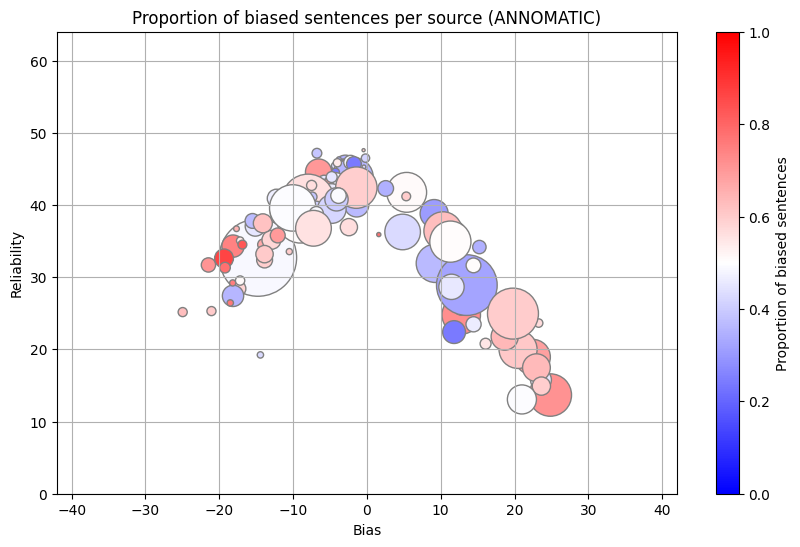

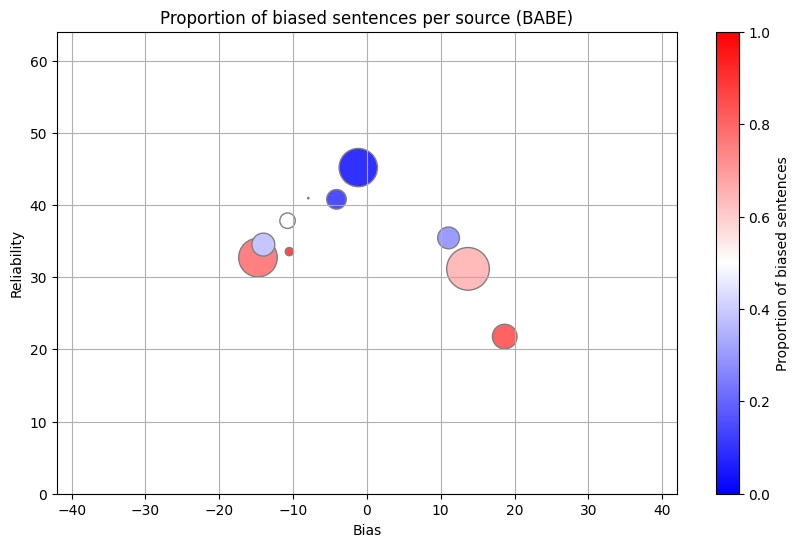

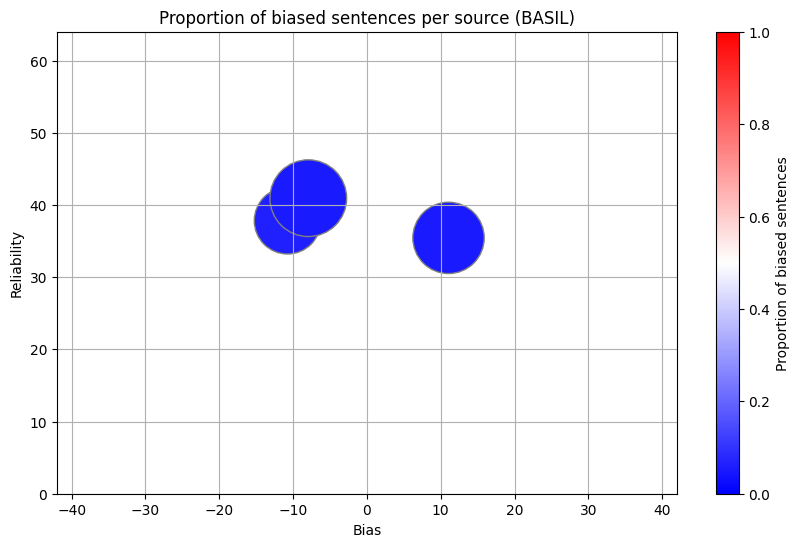

In [7]:
plot_bias_by_source(annomatic, "ANNOMATIC")
plot_bias_by_source(babe, "BABE")
plot_bias_by_source(basil, "BASIL")

Create subsets

In [ ]:
# 3 iterations, 500 sample size
subsamples_basil = create_subsets(basil_train, 3, 500)
subsamples_babe = create_subsets(babe_train, 3, 500)
subsamples_annomatic = create_subsets(annomatic, 3, 500)

div_subsamples_basil = process_vendi_scores(subsamples_basil)
div_subsamples_babe = process_vendi_scores(subsamples_babe)
div_subsamples_annomatic = process_vendi_scores(subsamples_annomatic)

# save subsample info
path = f"../data/subsamples/source/"
div_subsamples_annomatic.to_csv(os.path.join(path, "div_subsamples_annomatic.csv"))
div_subsamples_basil.to_csv(os.path.join(path, "div_subsamples_basil.csv"))
div_subsamples_babe.to_csv(os.path.join(path, "div_subsamples_babe.csv"))

In [71]:
save_subsamples(subsamples_basil, "basil")
save_subsamples(subsamples_babe, "babe")
save_subsamples(subsamples_annomatic, "annomatic")

Plot quintiles

In [134]:
def plot_quintiles_vs(df, name):
    cmap = mpl.colormaps['Set3']
    
    df["quintile"] = pd.Categorical(df["quintile"], ordered=True)
    # Group by quintile and get mean values
    quintile_means = df.groupby("quintile")[["vs", "normalized_vs"]].mean().reset_index()

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar plot for normalized_vs
    ax1.bar(
        quintile_means["quintile"].astype(str),  # Convert to string for better x-axis labeling
        quintile_means["normalized_vs"],
        color=cmap(0),
        label="Normalized Vendi Score",
    )
    ax1.set_ylabel("Normalized Vendi Score")
    ax1.set_title(f"Diversity Score by Quintile for {name}", fontsize=14)

    # Add secondary y-axis for vs
    ax2 = ax1.twinx()
    ax2.plot(
        quintile_means["quintile"].astype(str),  # Match x-axis
        quintile_means["vs"],
        color=cmap(0.3),
        marker="o",
        label="Vendi Score",
        linewidth=2,
    )
    ax2.set_ylabel("Vendi Score (effective number of sources)")

    # Add legends
    ax1.legend(loc="upper left", bbox_to_anchor=(0, 1), frameon=False)
    ax2.legend(loc="upper left", bbox_to_anchor=(0, 0.95), frameon=False)

    # Format x-axis
    ax1.set_xticks(range(len(quintile_means)))
    ax1.set_xticklabels(quintile_means["quintile"].astype(str), rotation=0)

    # Tight layout and show the plot
    plt.tight_layout()
    plt.show()

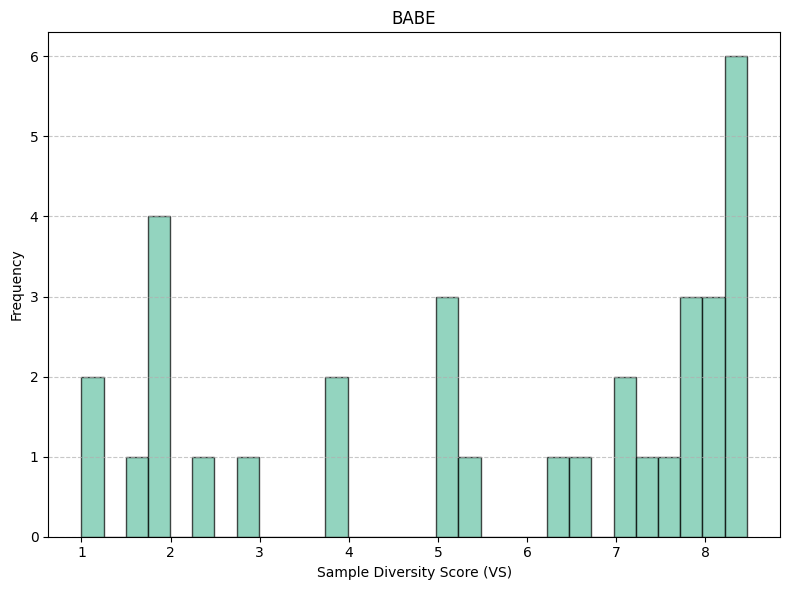

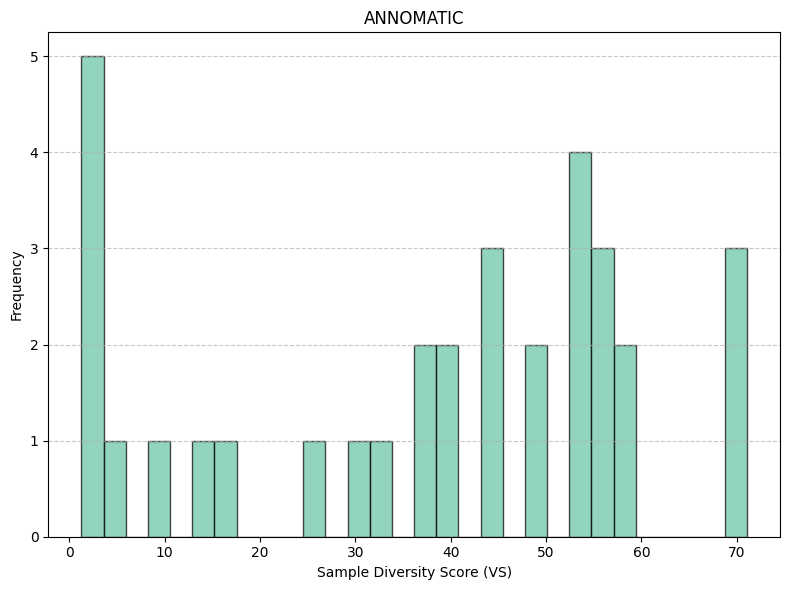

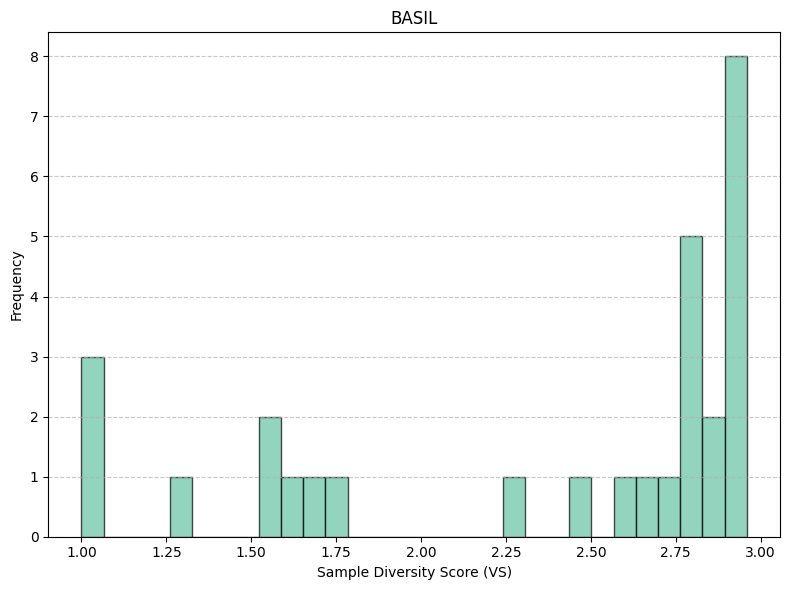

In [131]:
def plot_hist_vs(df, name):
    cmap = mpl.colormaps['Set2']
    plt.figure(figsize=(8, 6))
    plt.hist(df["vs"], bins=30, color=cmap(0), edgecolor='black', alpha=0.7)
    plt.xlabel('Sample Diversity Score (VS)')
    plt.ylabel('Frequency')
    plt.title(name)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


for name, df in {'BABE': div_subsamples_babe, 'ANNOMATIC': div_subsamples_annomatic, 'BASIL': div_subsamples_basil}.items():
    plot_hist_vs(df, name)

I don't think the quintiles are a good idea. But I think its necessary to normalize. Maybe interpret results with logisitic regression?

C:\Users\sofik\AppData\Local\Temp\ipykernel_25424\911205509.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_means = df.groupby("quintile")[["vs", "normalized_vs"]].mean().reset_index()


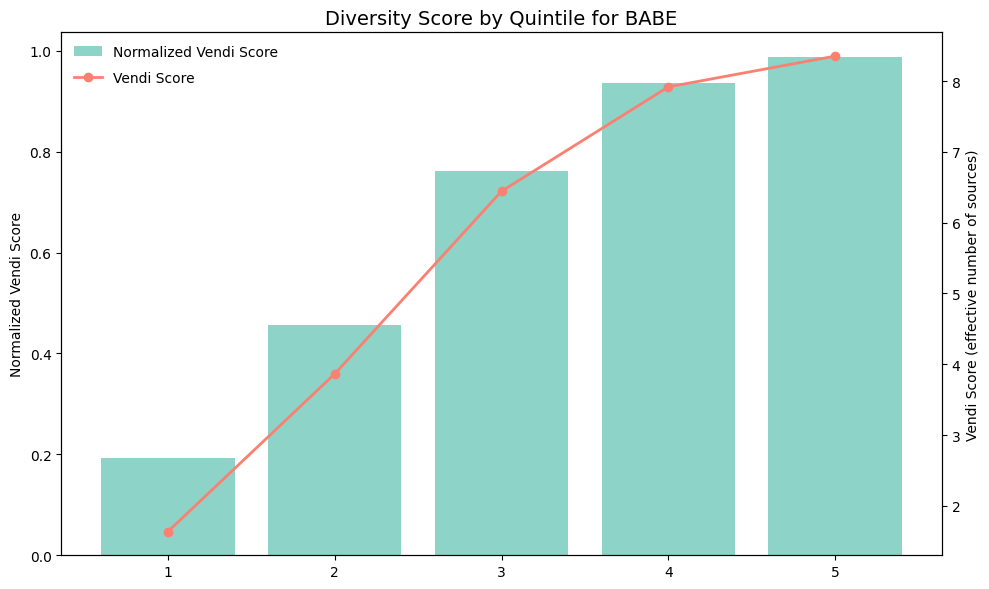

C:\Users\sofik\AppData\Local\Temp\ipykernel_25424\911205509.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_means = df.groupby("quintile")[["vs", "normalized_vs"]].mean().reset_index()


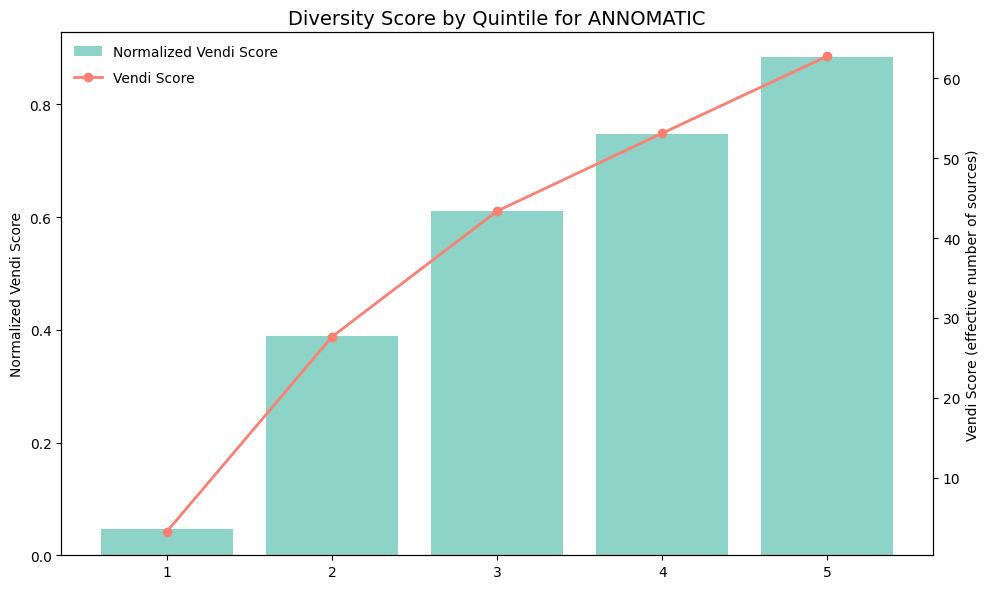

C:\Users\sofik\AppData\Local\Temp\ipykernel_25424\911205509.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_means = df.groupby("quintile")[["vs", "normalized_vs"]].mean().reset_index()


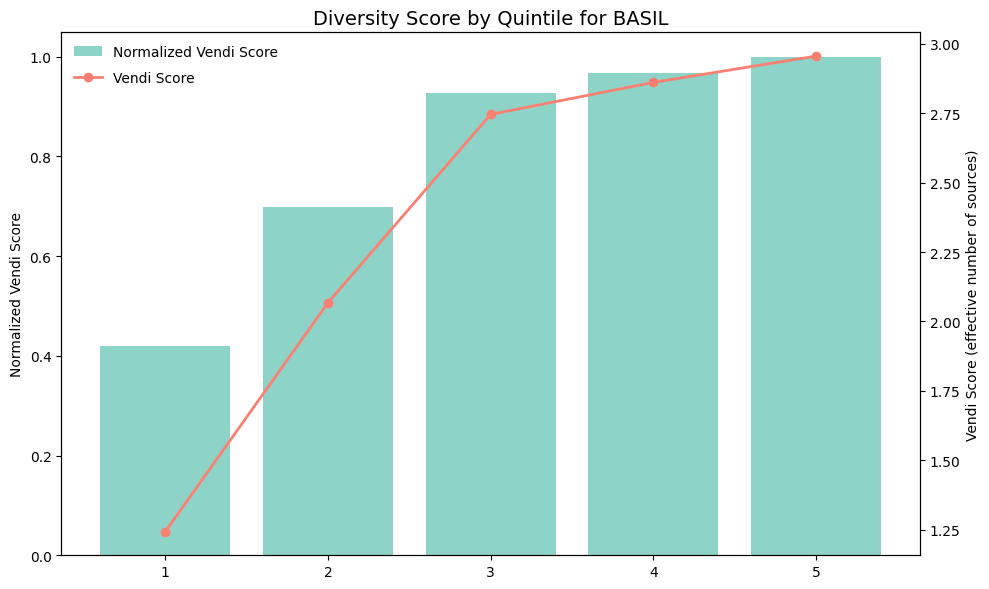

In [135]:
for name, df in {'BABE': div_subsamples_babe, 'ANNOMATIC': div_subsamples_annomatic, 'BASIL': div_subsamples_basil}.items():
    plot_quintiles_vs(df, name)

Example distribution

In [49]:
# subsamples_annomatic = create_subsets(annomatic, 3, 300)

def plot_distribution (df):
    # Get the counts for each adfontes_score
    score_counts = df["source"].value_counts()

    # Plotting the distribution with seaborn
    plt.figure(figsize=(12, 6))
    plt.bar(score_counts.index, score_counts.values, color=cmap(0))

    # Customize the plot
    plt.xlabel("Political Affiliation")
    plt.ylabel("Count")
    plt.xticks(rotation=90)  # Rotate x labels for better readability
    plt.tight_layout()

C:\Users\sofik\AppData\Local\Temp\ipykernel_32800\2171108308.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


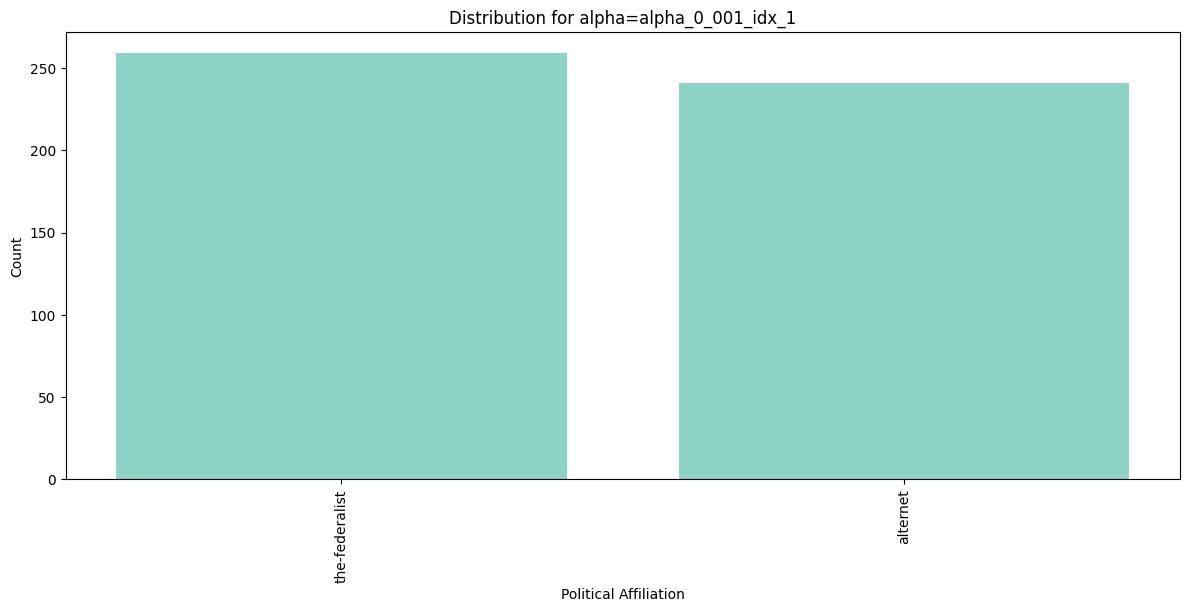

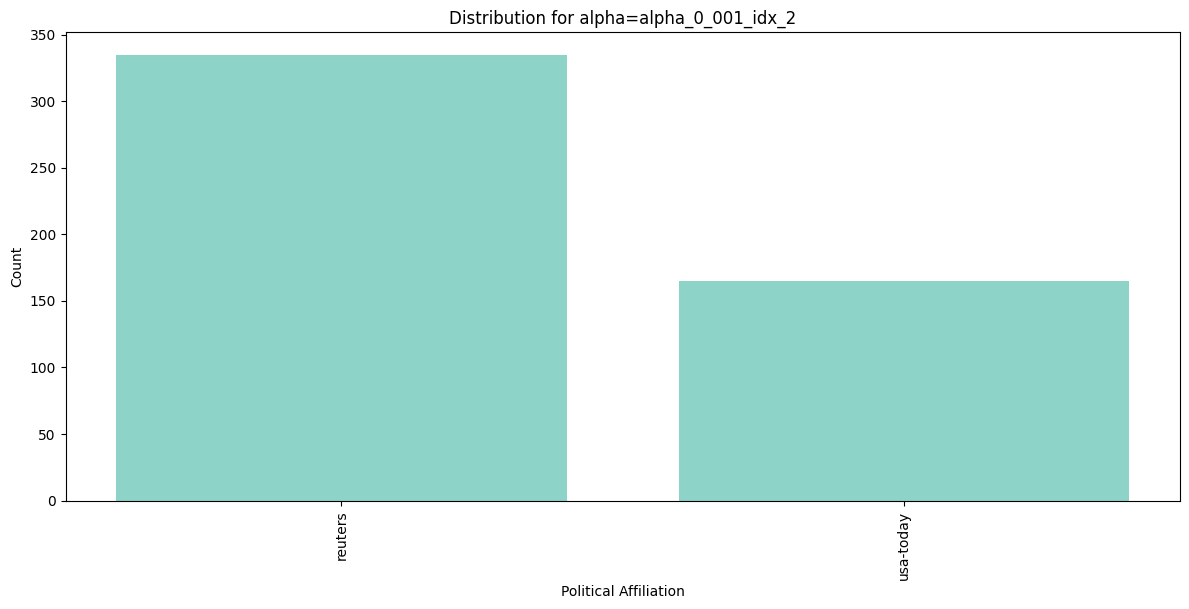

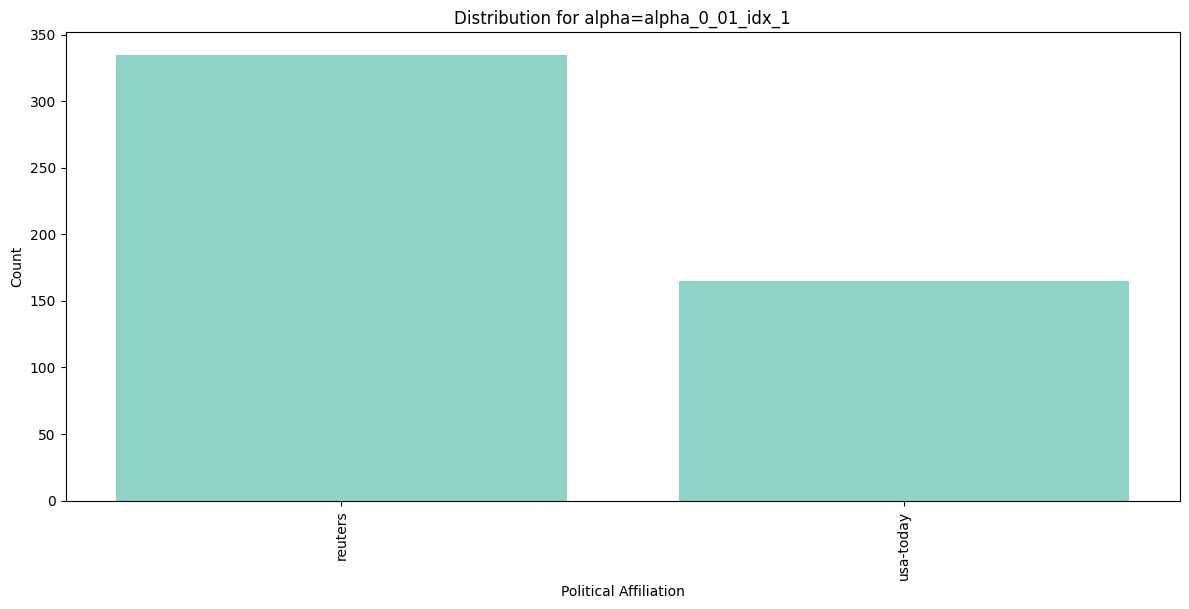

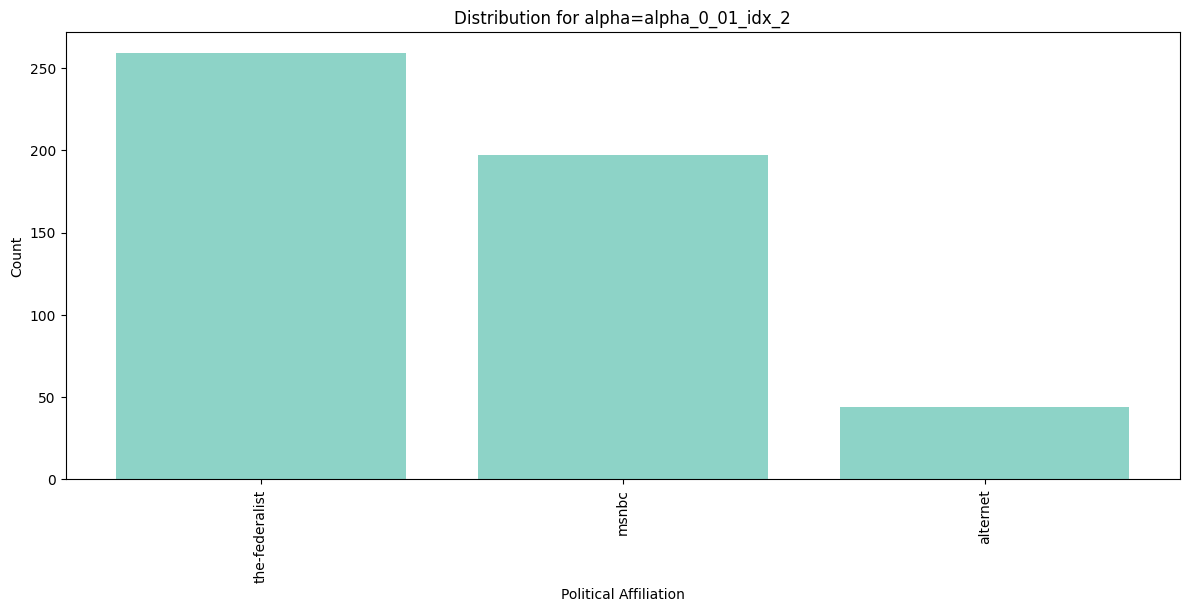

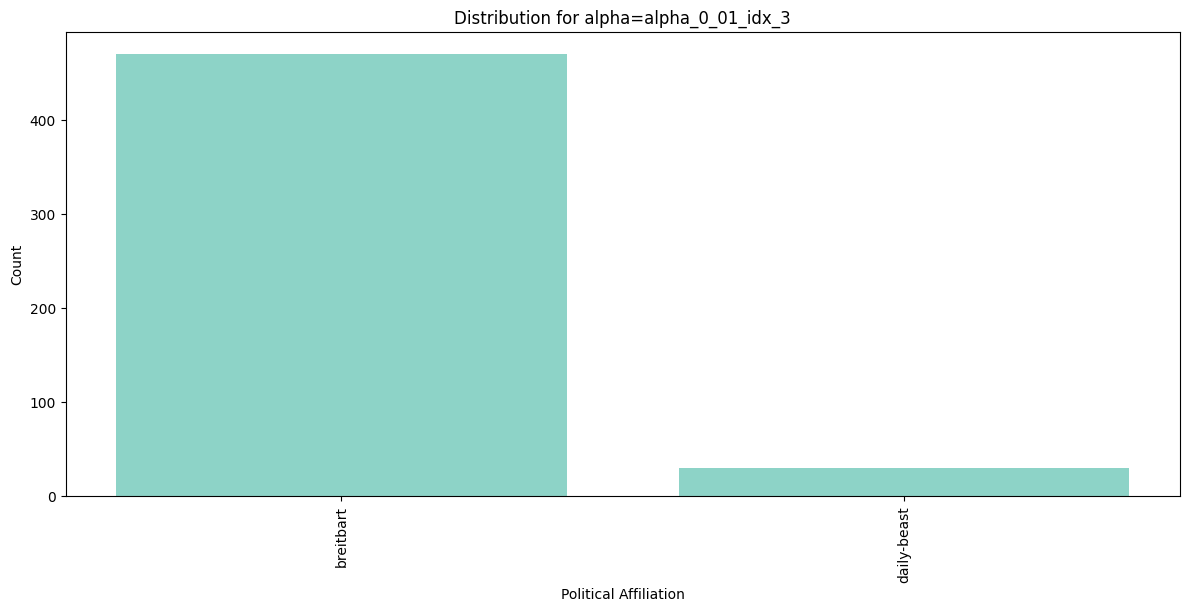

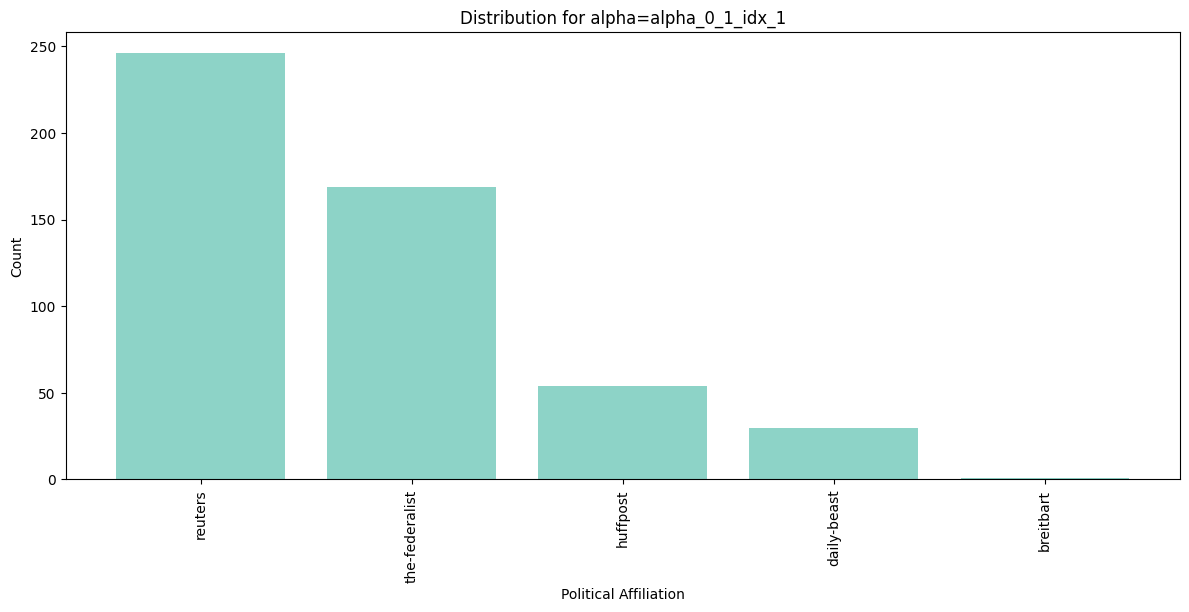

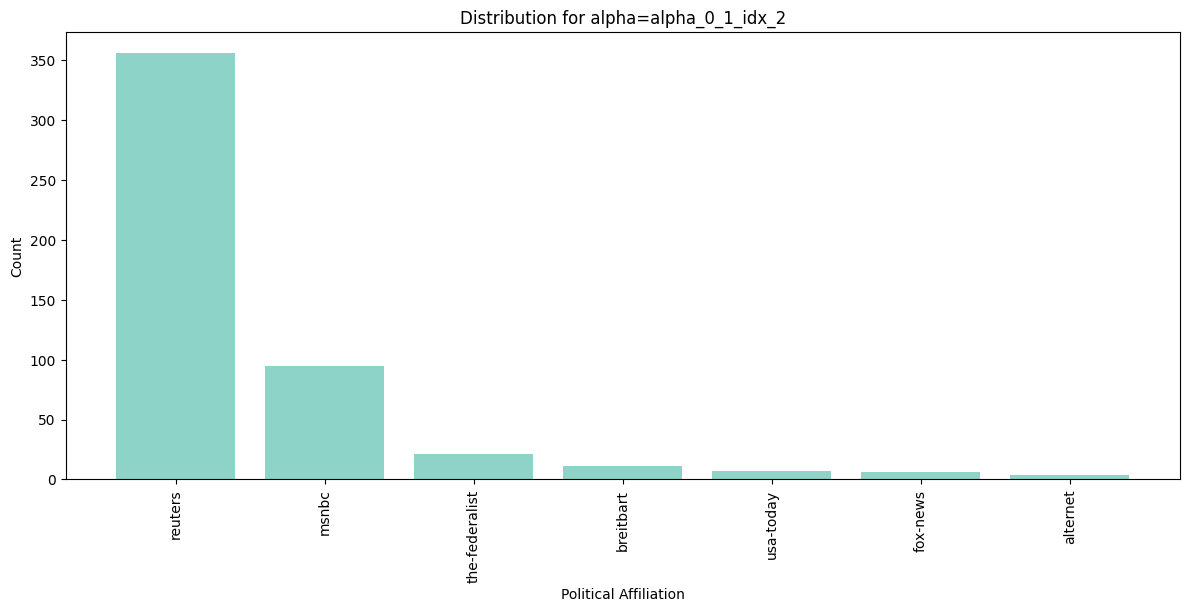

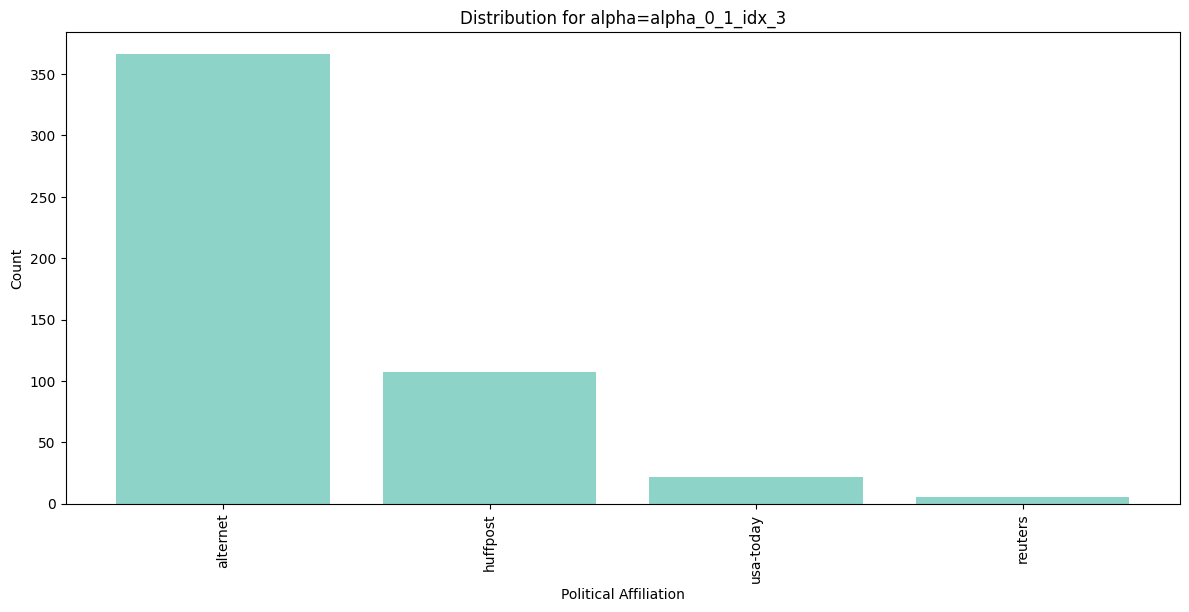

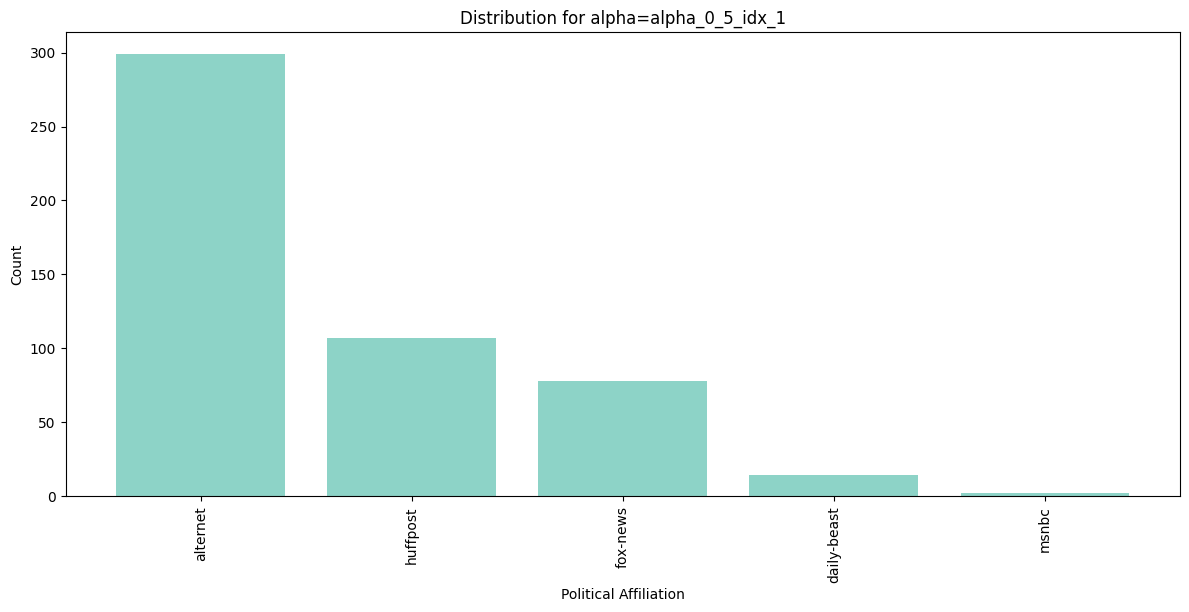

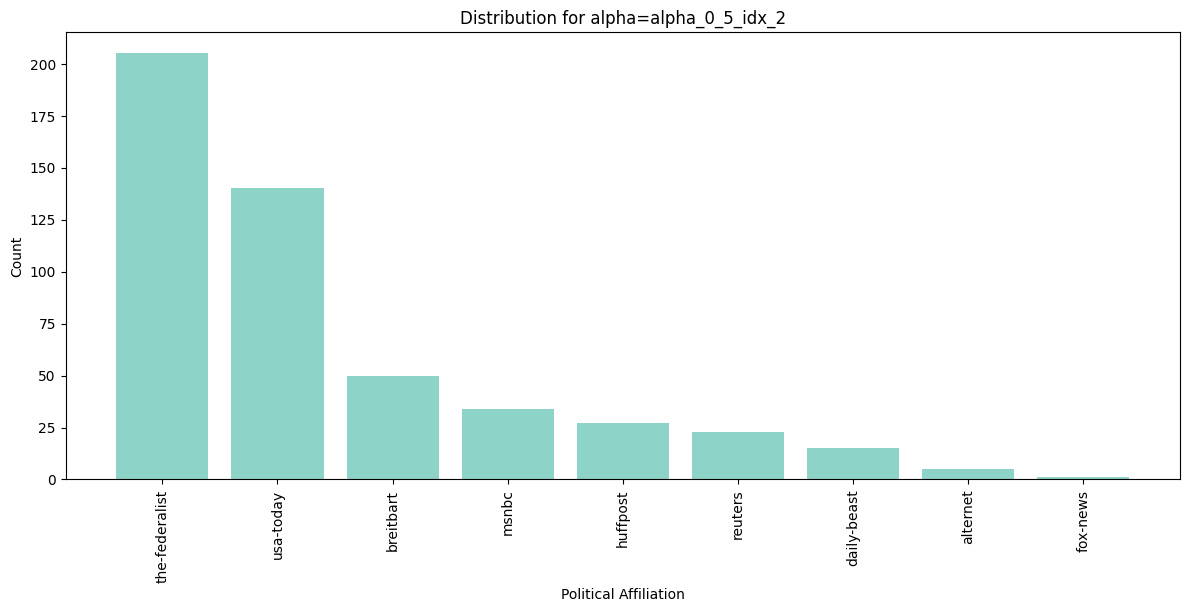

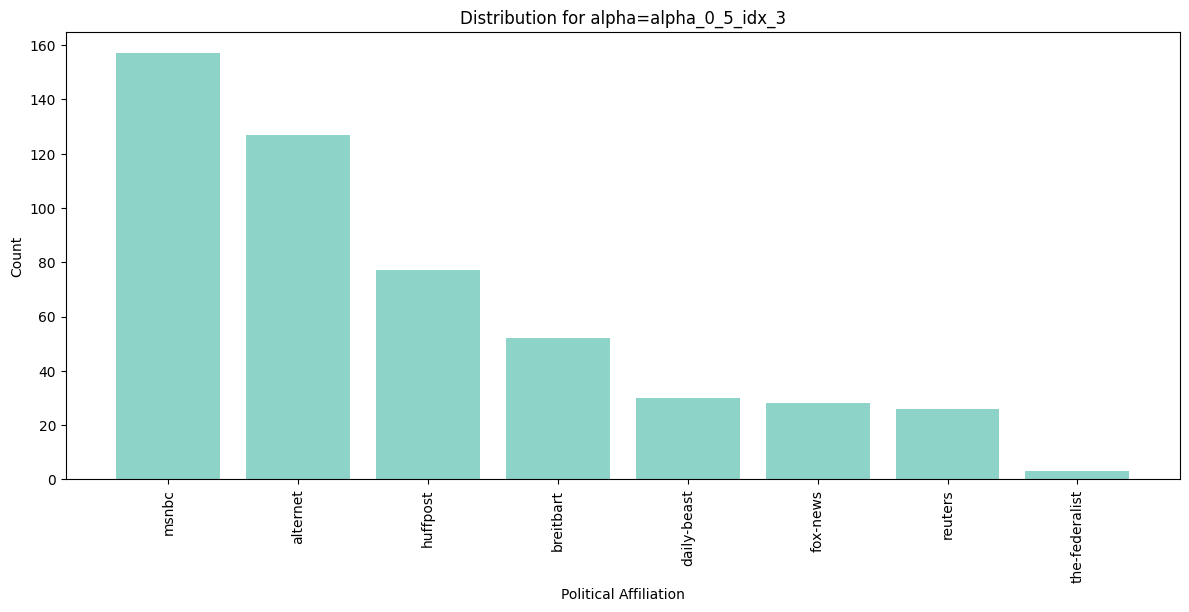

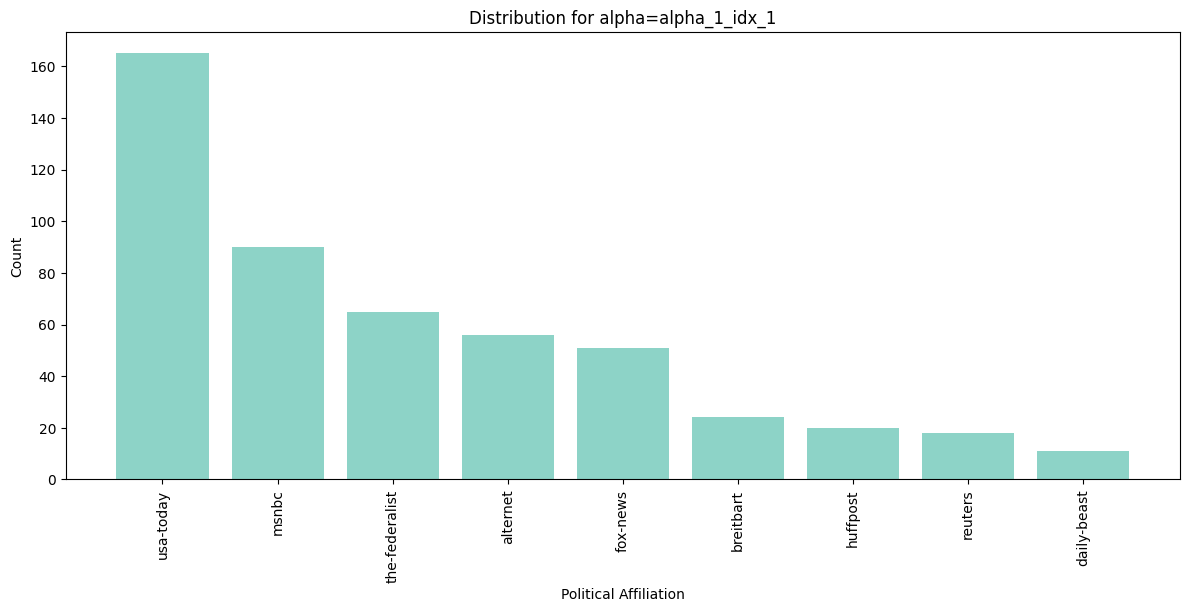

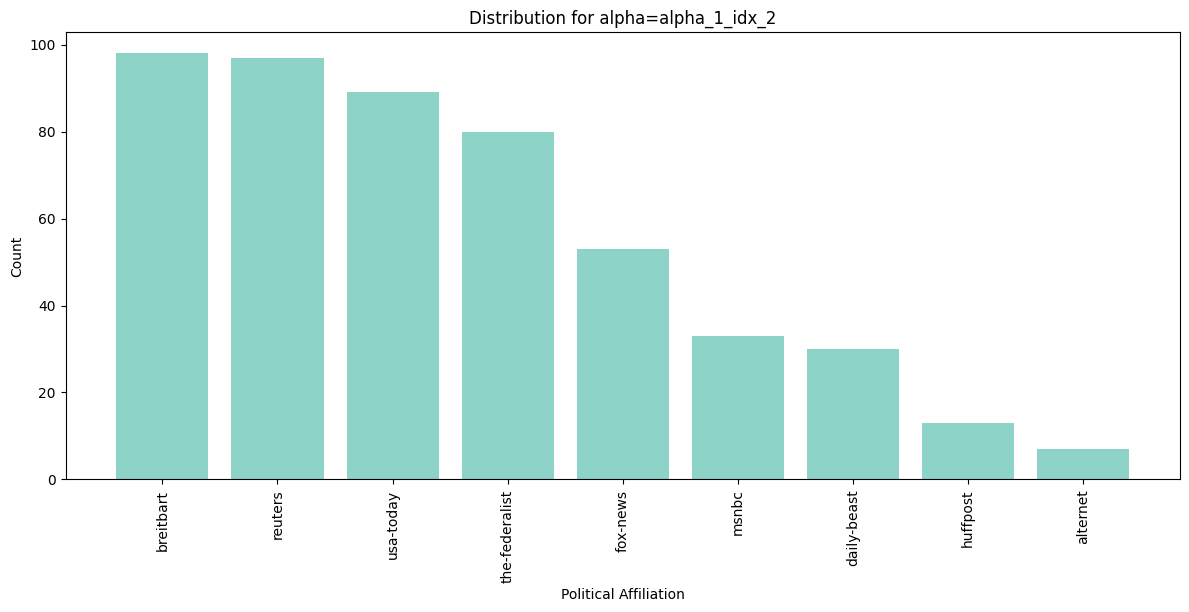

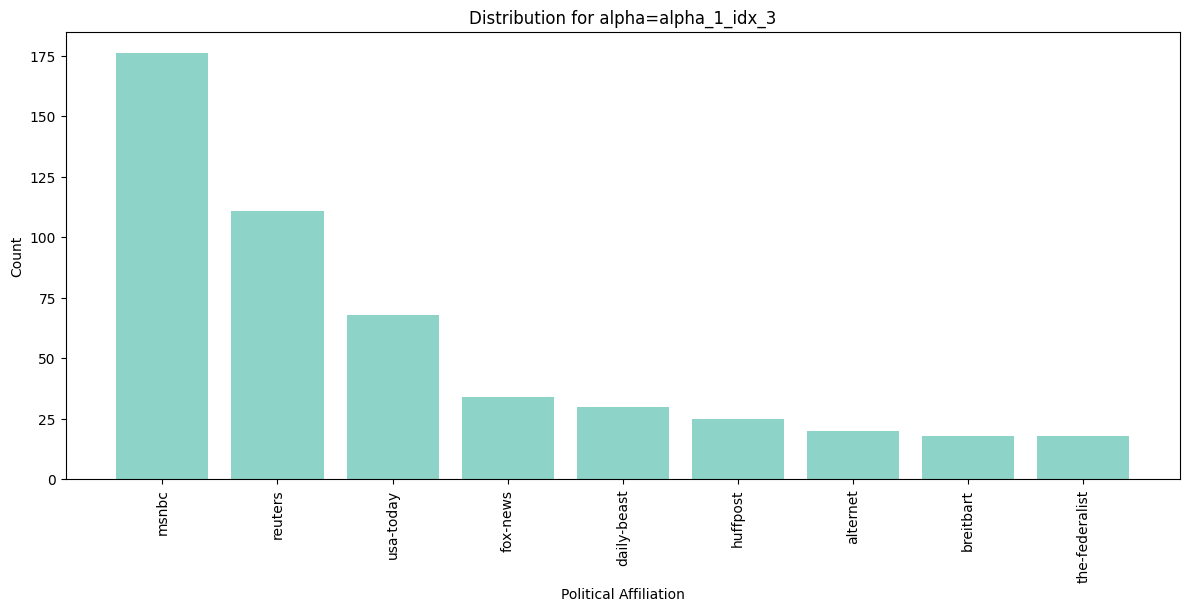

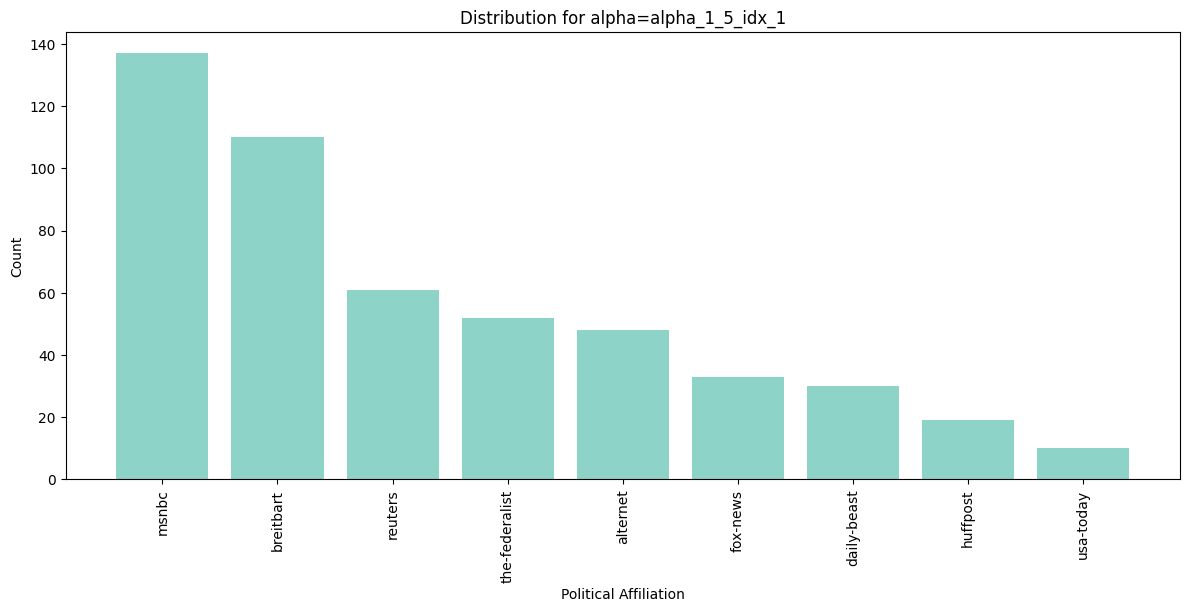

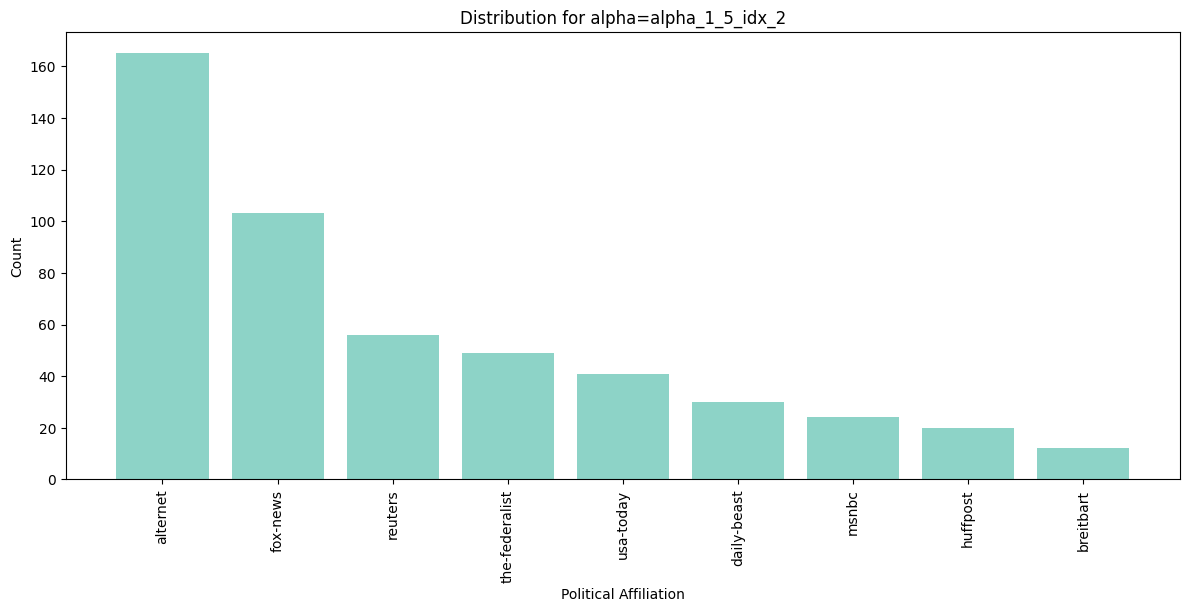

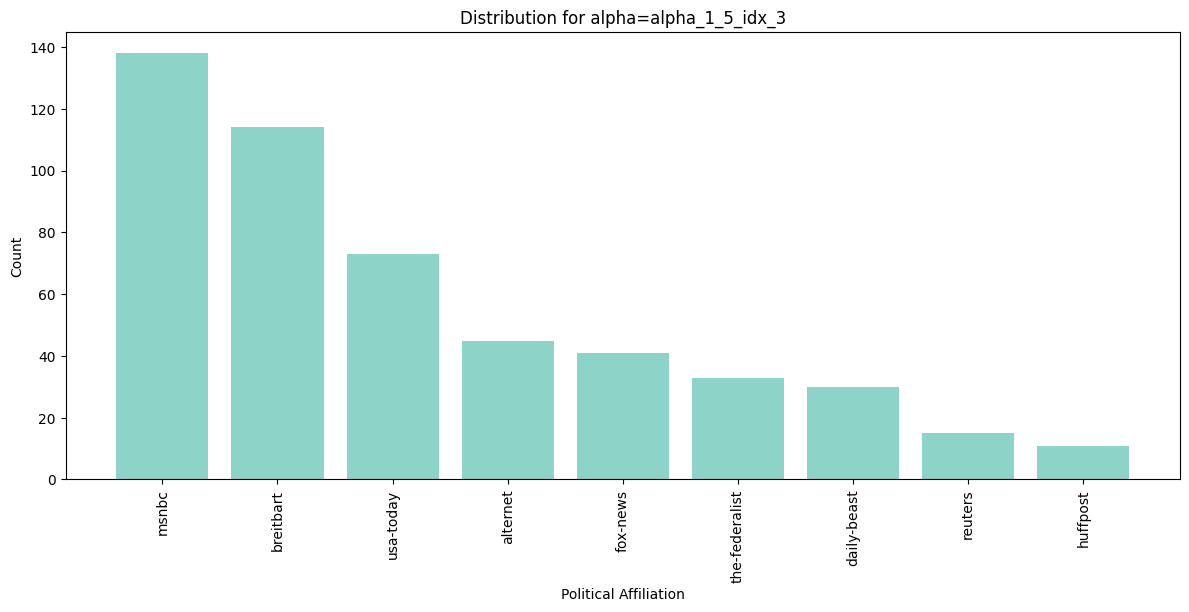

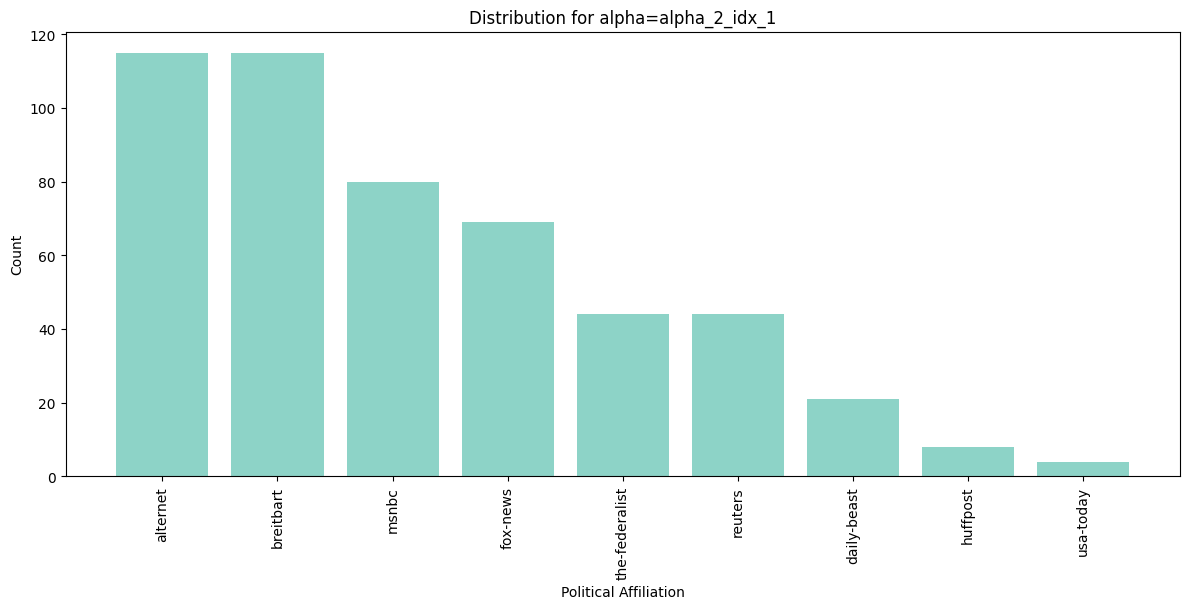

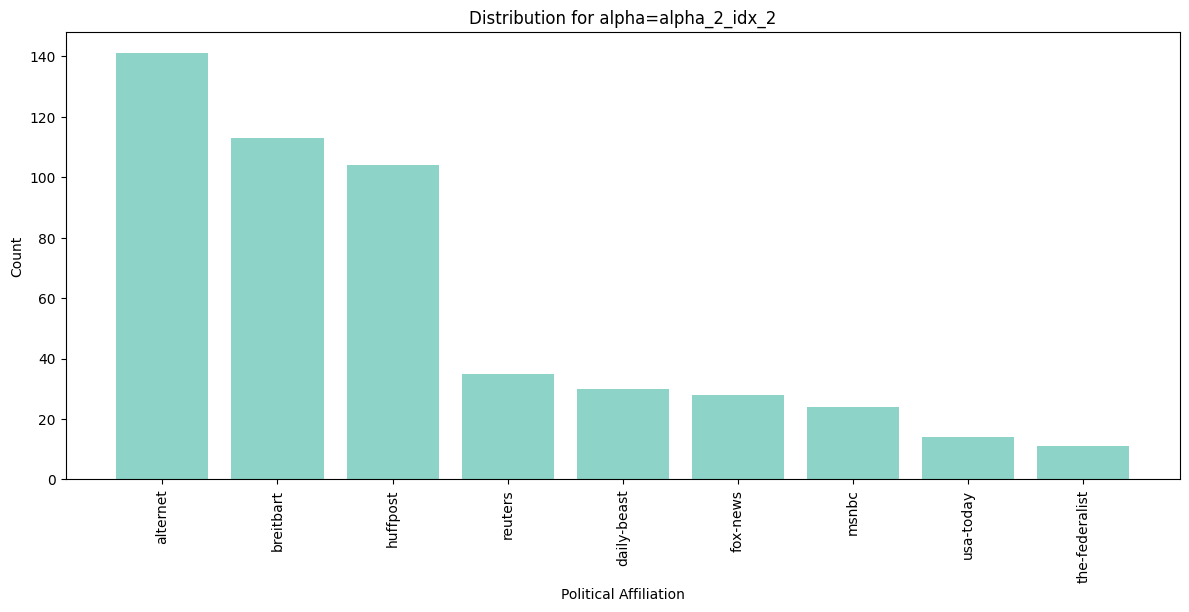

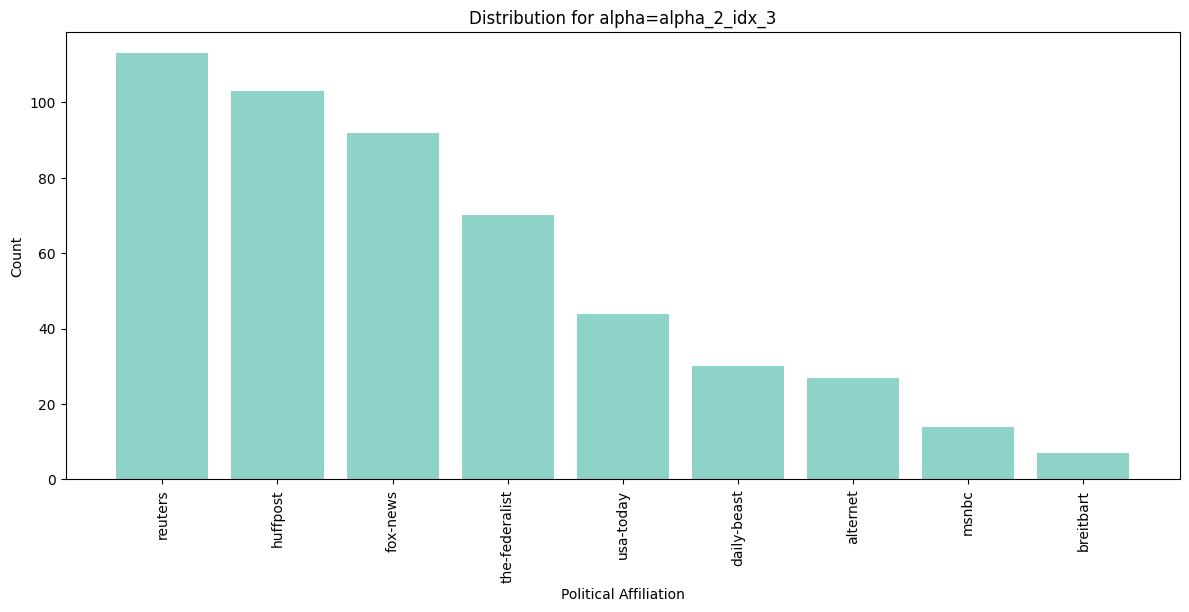

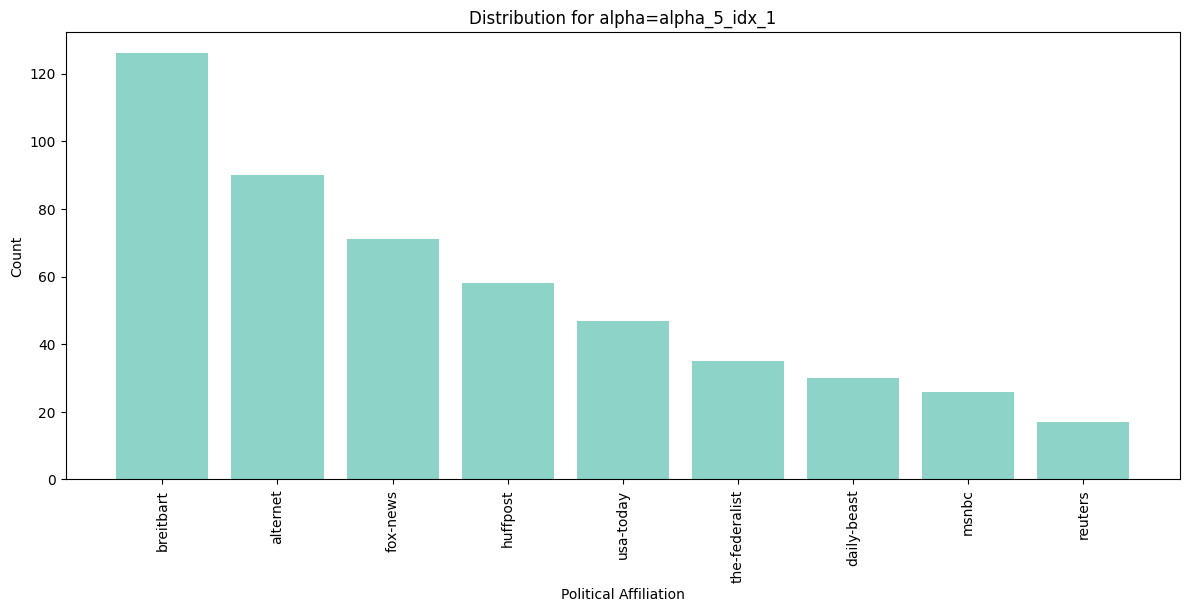

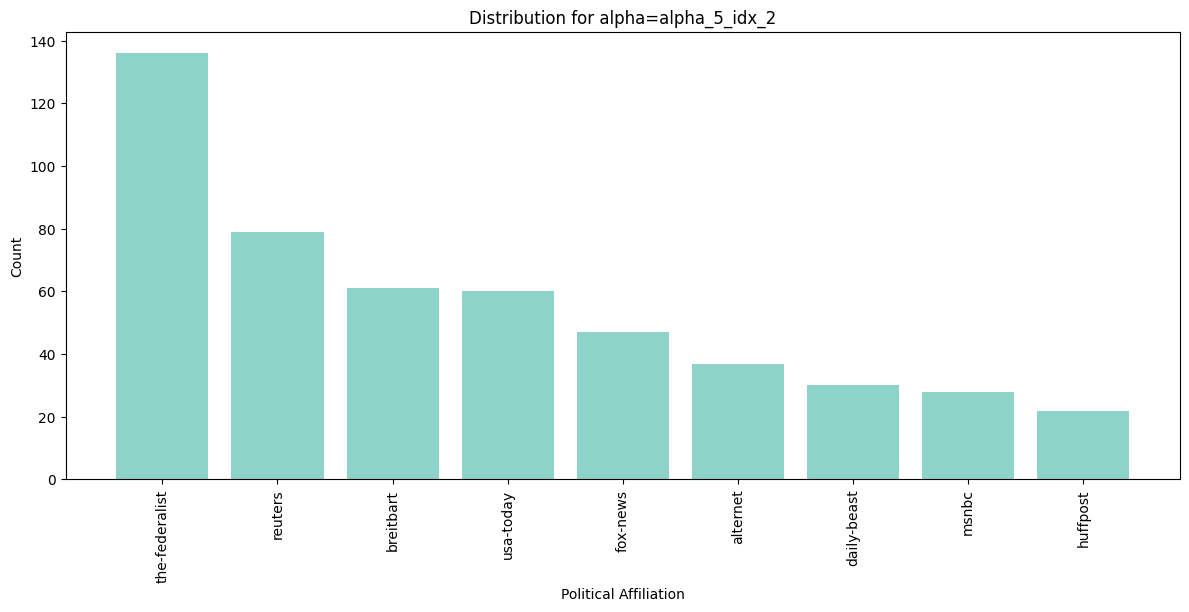

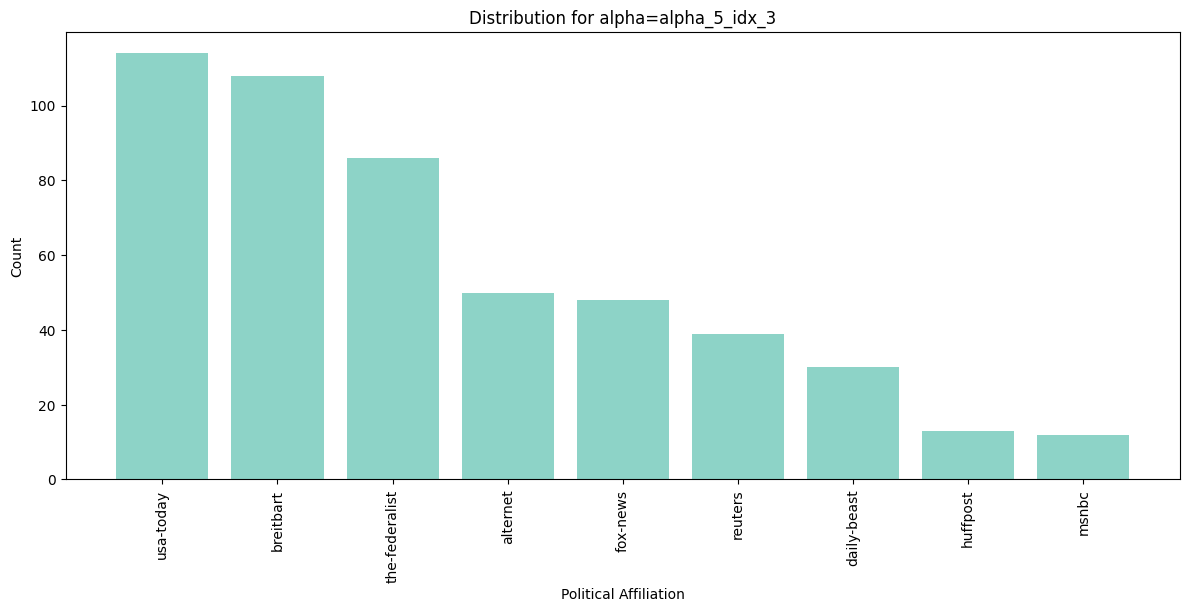

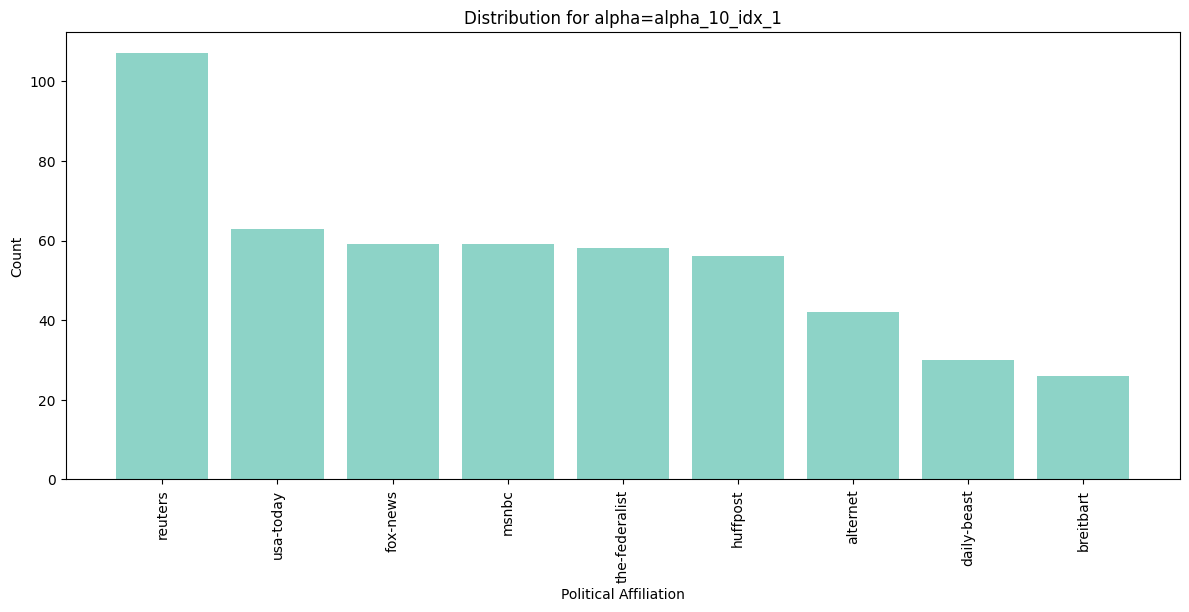

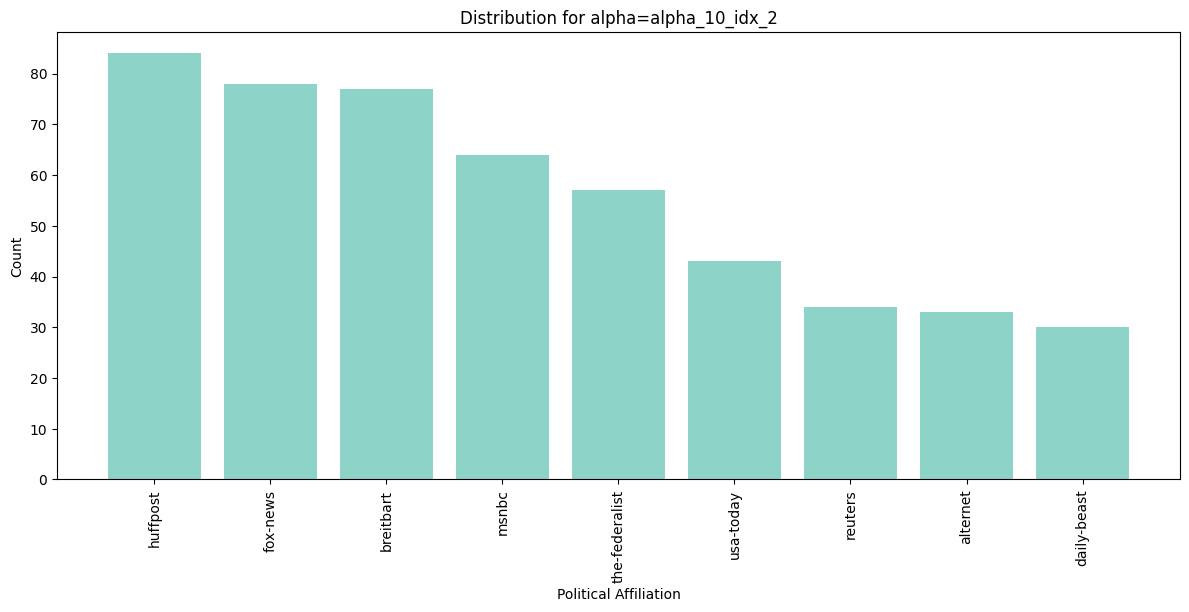

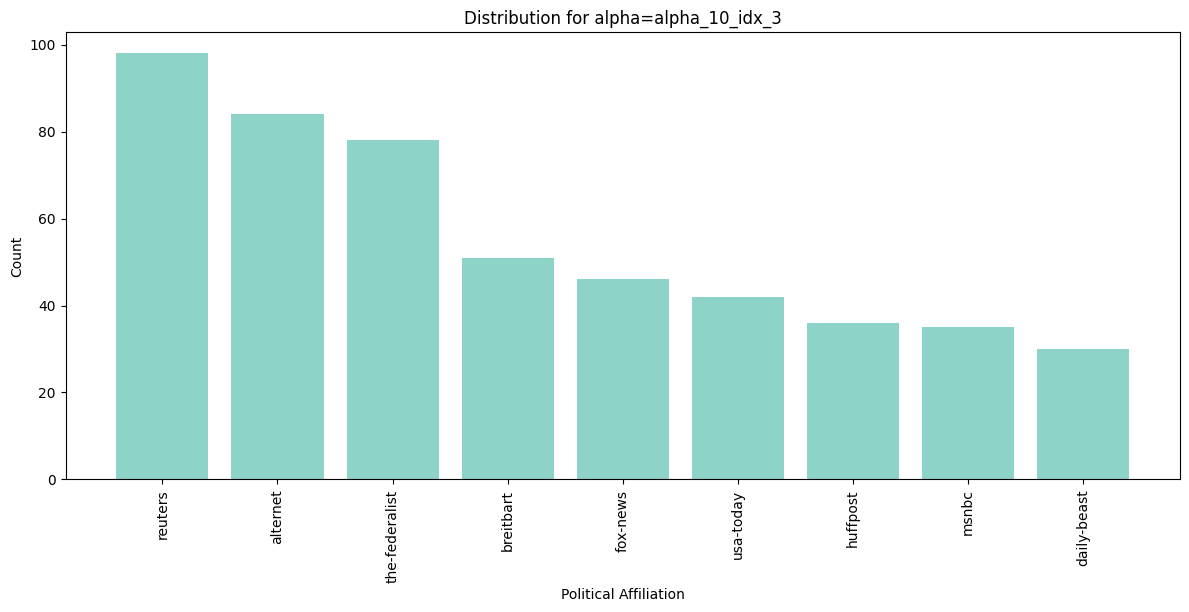

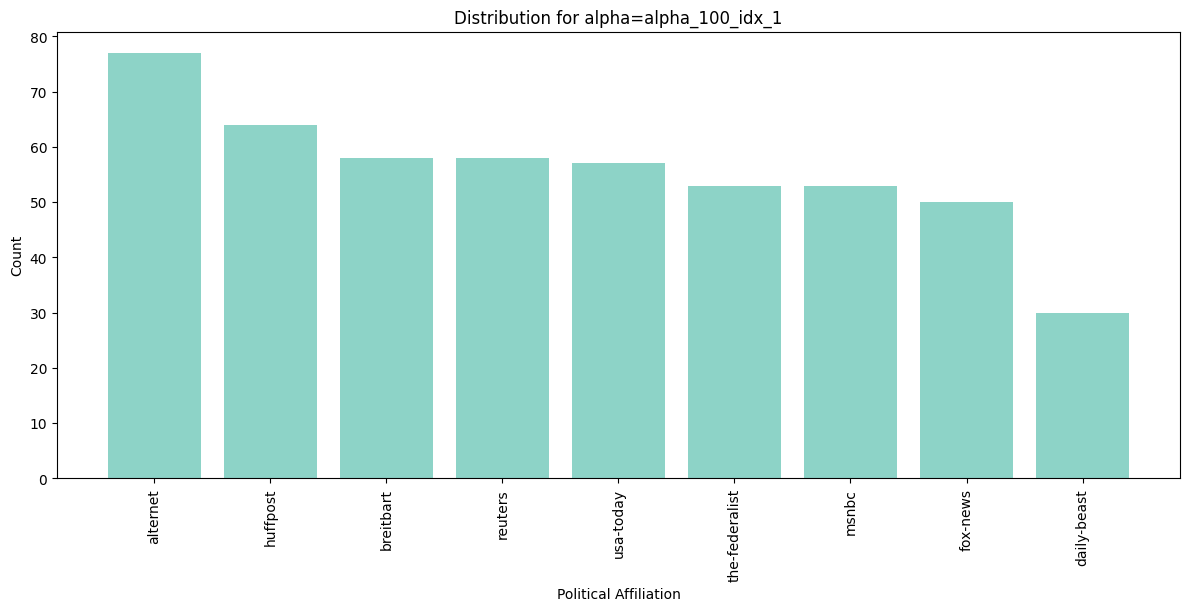

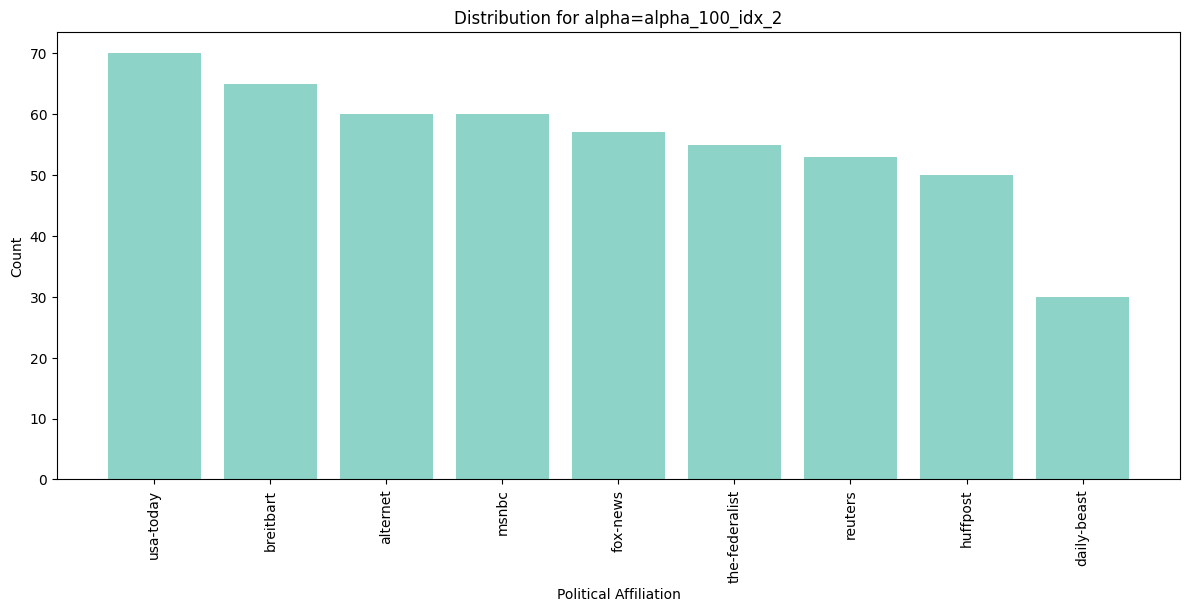

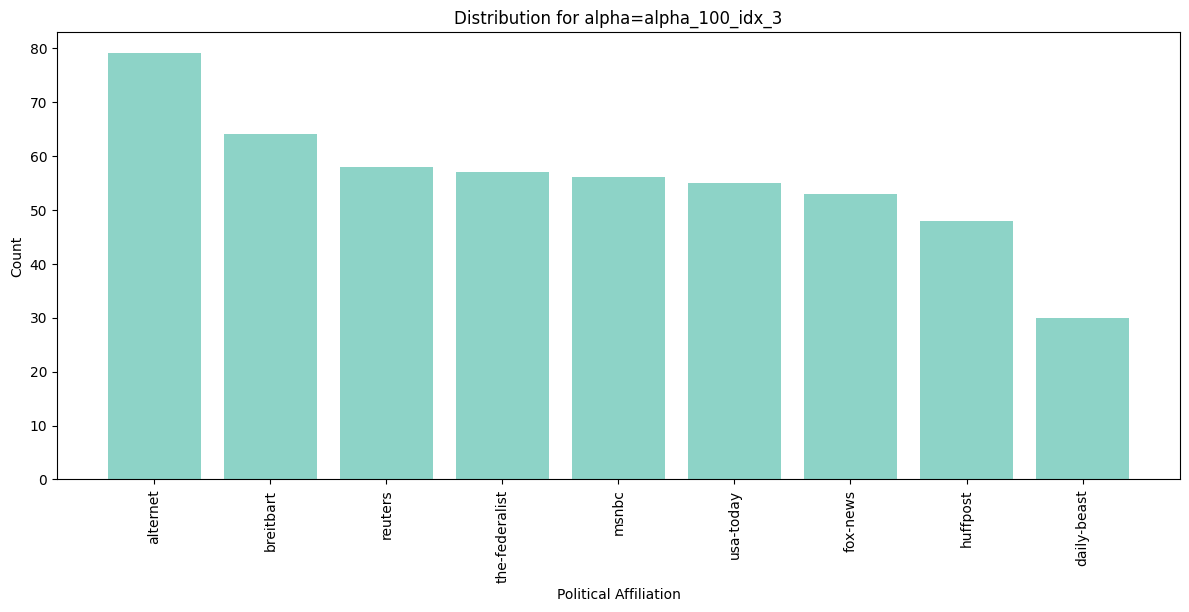

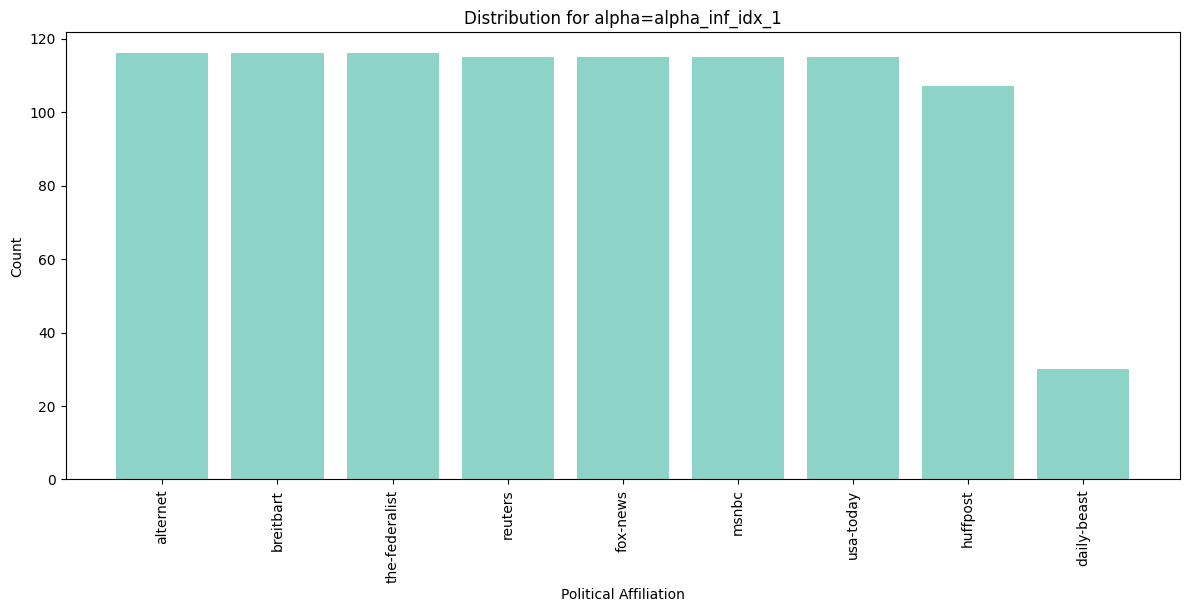

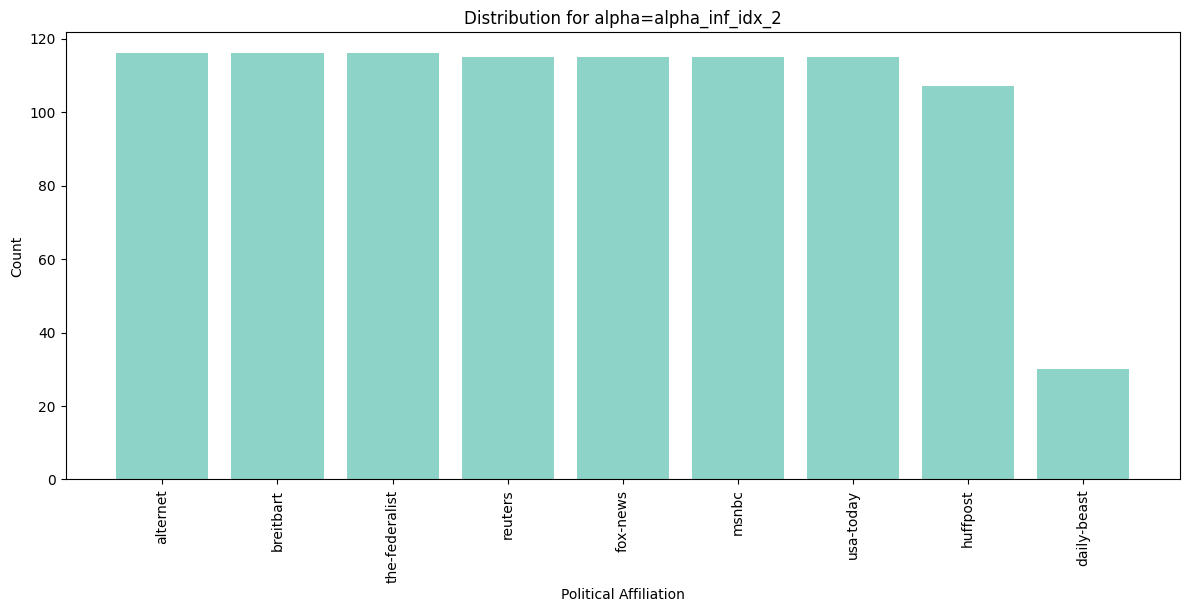

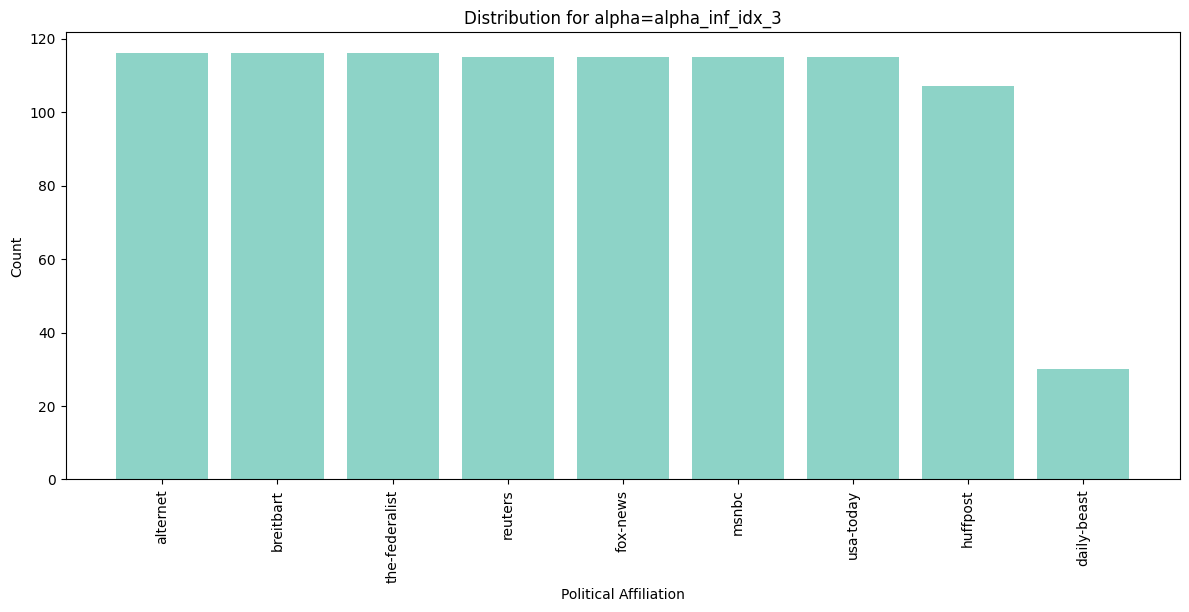

In [52]:
for alpha, value in subsamples_babe.items():
        sampled_df = value['data']
        plot_distribution(sampled_df)
        plt.title(f"Distribution for alpha={alpha}")